In [1]:
from scgenome import tantalus
import pandas as pd
from IPython.display import display
from scgenome import utils, cncluster, simulation, cnplot
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

In [3]:
all_cn_data_fp = "/Users/massoudmaher/data/sc1935_cn_data_qc.csv"
all_cn_data = pd.read_csv(all_cn_data_fp)
all_cn_data = all_cn_data.iloc[:,1:]

In [3]:
# bhc params
n_states = 12
alpha = 0.3
prob_cn_change = 0.8
bhc_incon = 2 # inconsistent score used for making clusters from bhc
bhc_depth = 2 

# naive clusering params
naive_method = "complete"
naive_metric = "cityblock"
naive_incon = 1.1
naive_depth = 2

# Params for testing threshold values
params = simulation.expand_grid({"transform":["log","none"], "criterion": ["inconsistent"], "threshold": np.arange(0.025, 2, step=0.05)})
params = pd.concat([params, simulation.expand_grid({"transform":["log","none"], "criterion": ["distance"], "threshold": np.arange(3, 20, step=1)})])

In [6]:
len(set(all_cn_data["cell_id"].unique()))

295

In [5]:
start = time.time()
bhc_linkage, bhc_root, bhc_cell_ids, matrix_data, measurement, variances = (
    cncluster.bayesian_cluster(mixed_cn_data, n_states=n_states, alpha=alpha, prob_cn_change=prob_cn_change)
)
print(f"{time.time()-start}s for BHC on {total_ncells} cells")

149.8293068408966s for BHC on 100 cells


In [6]:
bhc_linkage, bhc_plot_data = simulation.get_plot_data(bhc_linkage)
lbhc_plot_data = bhc_plot_data.copy()
lbhc_plot_data[:,2] = np.log(lbhc_plot_data[:,2]) # Log because the highest link is way higher

naive_linkage = sch.linkage(measurement, method=naive_method, metric=naive_metric)
lnaive_linkage = naive_linkage.copy()
lnaive_linkage[:,2] = np.log(lnaive_linkage[:,2])

In [7]:
def apply_fn(row):
    if row["transform"] == "log":
        df = lbhc_plot_data
    else:
        df = bhc_plot_data
    return sch.fcluster(df, row["threshold"], criterion=row["criterion"])
params["bhc_fcluster"] = params.apply(apply_fn, axis=1)
params["bhc_num_clusters"] = params["bhc_fcluster"].apply(lambda x: len(set(x)))

def apply_fn(row):
    if row["transform"] == "log":
        df = lnaive_linkage
    else:
        df = naive_linkage
    return sch.fcluster(df, row["threshold"], criterion=row["criterion"])
params["naive_fcluster"] = params.apply(apply_fn, axis=1)
params["naive_num_clusters"] = params["naive_fcluster"].apply(lambda x: len(set(x)))

params.head()

,transform,criterion,threshold,bhc_fcluster,bhc_num_clusters,naive_fcluster,naive_num_clusters
0,log,inconsistent,0.025,"[1, 39, 1, 40, 50, 2, 53, 41, 51, 45, 54, 46, ...",57,"[30, 13, 30, 14, 7, 31, 4, 22, 3, 16, 6, 20, 2...",76
1,log,inconsistent,0.075,"[1, 39, 1, 40, 50, 2, 53, 41, 51, 45, 54, 46, ...",57,"[30, 13, 30, 14, 7, 31, 4, 22, 3, 16, 6, 20, 2...",76
2,log,inconsistent,0.125,"[1, 39, 1, 40, 50, 2, 53, 41, 51, 45, 54, 46, ...",57,"[30, 13, 30, 14, 7, 31, 4, 22, 3, 16, 6, 20, 2...",76
3,log,inconsistent,0.175,"[1, 39, 1, 40, 50, 2, 53, 41, 51, 45, 54, 46, ...",57,"[30, 13, 30, 14, 7, 31, 4, 22, 3, 16, 6, 20, 2...",76
4,log,inconsistent,0.225,"[1, 39, 1, 40, 50, 2, 53, 41, 51, 45, 54, 46, ...",57,"[30, 13, 30, 14, 7, 31, 4, 22, 3, 16, 6, 20, 2...",76


/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


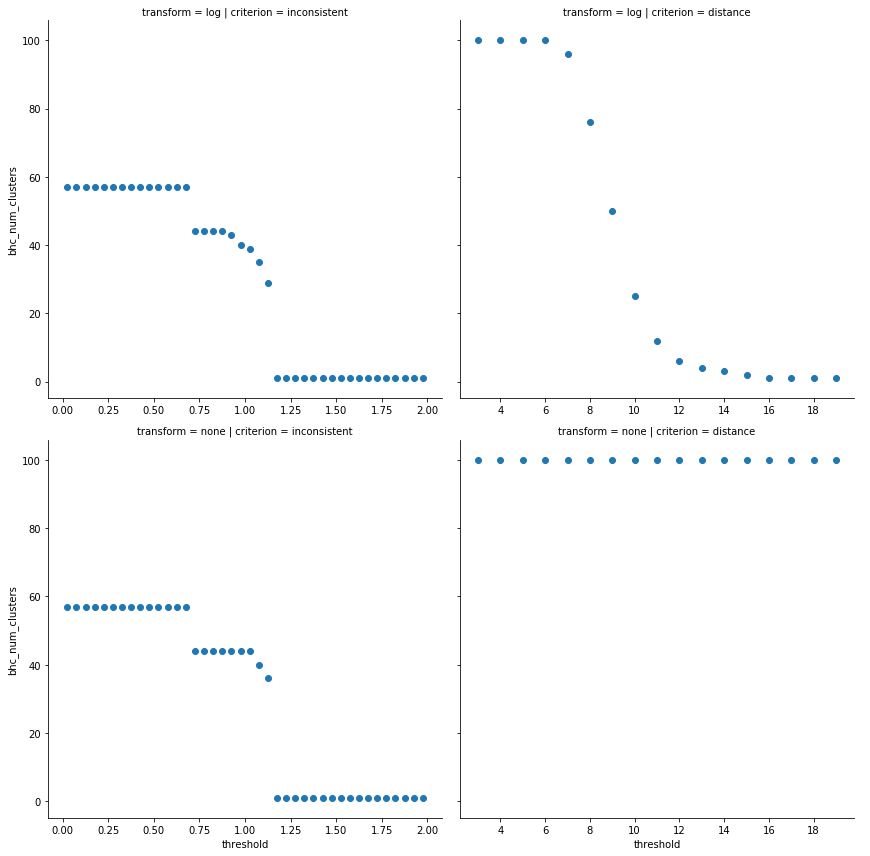

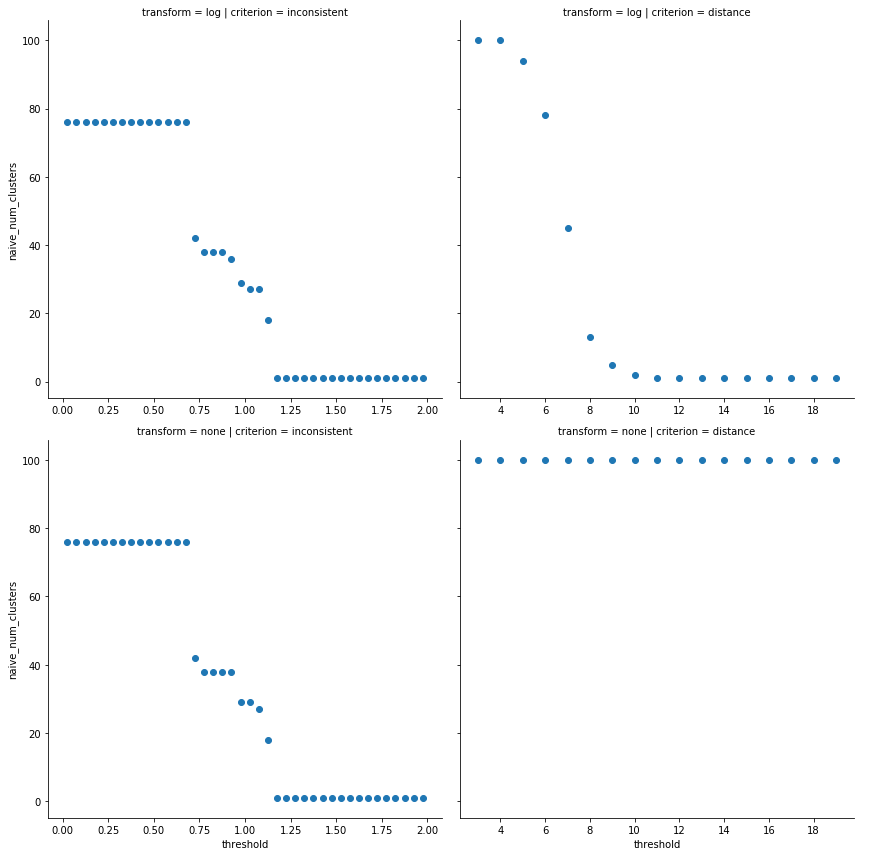

In [8]:
g = sns.FacetGrid(data=params, col="criterion", row="transform", size=6, sharey=True, sharex=False).add_legend()
g = g.map(plt.scatter, "threshold", "bhc_num_clusters")

g = sns.FacetGrid(data=params, col="criterion", row="transform", size=6, sharey=True, sharex=False).add_legend()
g = g.map(plt.scatter, "threshold", "naive_num_clusters")

## Rightmost bar represents where sample originally came frome

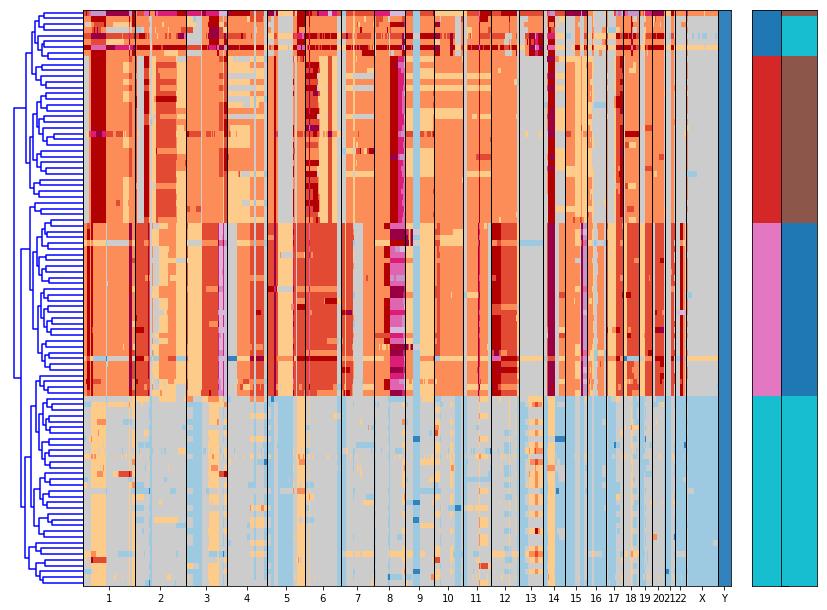

In [9]:
cmixed_cn_data = mixed_cn_data.copy()
clustering = sch.fcluster(lbhc_plot_data, 13, criterion="distance")
cmixed_cn_data = cncluster.prune_cluster(clustering, bhc_cell_ids, mixed_cn_data)

fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, cmixed_cn_data, "state", cluster_field_name="bhc_cluster_id",
    linkage=lbhc_plot_data, origin_field_name="origin_id_int")

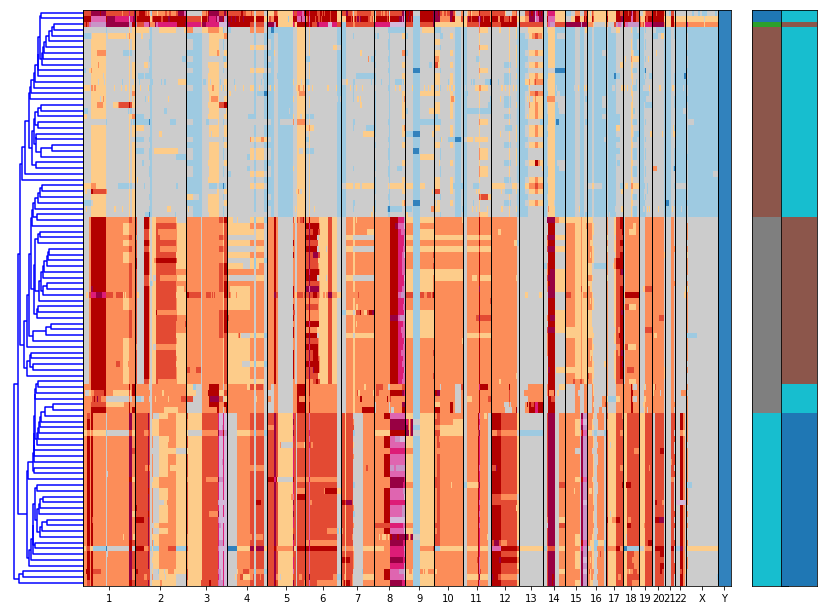

In [10]:
naive_clusters = sch.fcluster(lnaive_linkage, 9, criterion="distance")
assert len(set(naive_clusters)) > 1
nmixed_cn_data = cncluster.prune_cluster(naive_clusters, bhc_cell_ids, mixed_cn_data, 
                                         cluster_field_name="naive_cluster_id")
fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, nmixed_cn_data, "state", cluster_field_name="naive_cluster_id",
    linkage=lnaive_linkage, origin_field_name="origin_id_int")

/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 6 separate connected components using meta-embedding (experimental)
  n_components
/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 6 separate connected components using meta-embedding (experimental)
  n_components
/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Users/massoudmahe

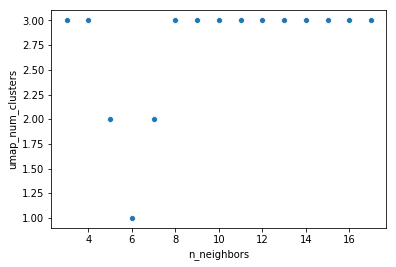

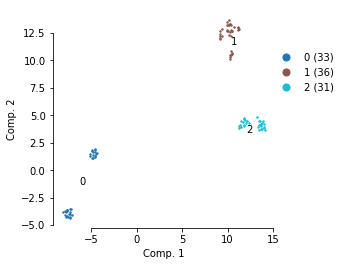

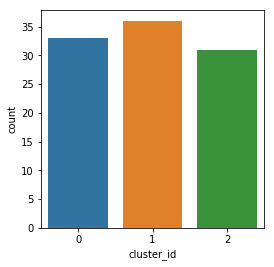

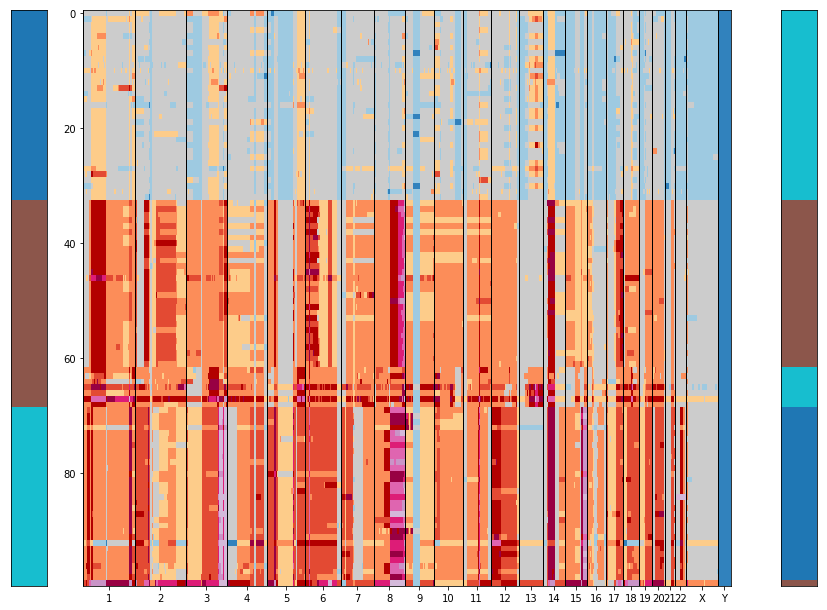

In [12]:
umap_params = utils.expand_grid({"n_neighbors": np.arange(3,18,step=1)})
def apply_fn(row):
    return cncluster.umap_hdbscan_cluster(matrix_data["state"], n_neighbors=row["n_neighbors"])

umap_params["umap_clusters"] = umap_params.apply(apply_fn, axis=1)
umap_params["umap_num_clusters"] = umap_params["umap_clusters"].apply(lambda x: len(set(x["cluster_id"])))

sns.scatterplot(data=umap_params, x="n_neighbors", y="umap_num_clusters")

umap_df = cncluster.umap_hdbscan_cluster(matrix_data["state"], n_neighbors=10)
umixed_cn_data = mixed_cn_data.merge(umap_df, how="inner")

fig = plt.figure(figsize=(4, 4))
cncluster.plot_umap_clusters(plt.gca(), umap_df)

fig = plt.figure(figsize=(4, 4))
sns.barplot(x='cluster_id', y='count', data=umap_df.groupby('cluster_id').size().rename('count').reset_index())


fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, umixed_cn_data, "state", cluster_field_name="cluster_id",
    linkage=None, origin_field_name="origin_id_int")
#def umap_hdbscan_cluster(
#        cn,
#        n_components=2,
#        n_neighbors=15,
#        min_dist=0.1,
#):

Umap does better-- especially considering that it runs way faster